## Opening an image
The first step that we are going to do is open an image and have a quick look at it. I am going to open the image examine some key information from the header and then view a few slices of it with.
* Dimensions
* Transformation


# Imaging biomarker extraction walkthrough
This notebook will go over some examples of extacting biomarkers from structural T1 weighted MR images and amyloid PET data. These are some of the most widely used biomarkers that are used in AD research. They are also measures used in the EBM. The walkthrough will use some freely available, widely used open-source software packages as an example of how to perform this analysis. However, there are many other methods out there to choose from and determine which one would be right for your data and application.

## Preparation
First up, we need to import some packages into our notebook so that we can use them. For the purposes of this notebook, we will use [nipype](https://nipype.readthedocs.io/en/latest/) a handy workflow engine in Python that allows you to piece together different elements from different popular neuroimaging software packages. In addition to interrogate some information about the images, we will also use the packages [nibabel](https://nipy.org/nibabel/). 

In [1]:
import os
import nibabel as nb
import nipype   

## Image basics
Let's first load in an image into memory and see some basic information about it. 


In [8]:
data_root = "/Users/davecash/Data/IDEAS"
img_name = os.path.join(data_root,"nifti","02-021-11_20151120130726_2.nii.gz")
img = nb.load(img_name)
img.shape
img.header['dim']

array([  3, 208, 256, 256,   1,   1,   1,   1], dtype=int16)

The output says that we have 208 rows and 256 columns per image slice and there are 256 slices in the volume. We typically denote voxel locations as *i*, *j*, and *k*. I have chosen voxel location (100,100,100) which means the voxel at row 100 and column 100 within slice 100. 


In [17]:
test_voxel = (100,100,100)
img_data = img.get_fdata()
print(img_data[test_voxel])

265.0


Python starts counting at **zero**, so this row 100 is actually the 101st row in the matrix. It also means that the indexes used to access the voxels inside the array go frrom rows 0 to 207, not 1 to 208, and columns from 0 to 255, not 1 to 256. Watch what happens if I want to get the first row and column in the last slice if I think Python is counting from 1.

In [9]:
last_voxel=(1,1,256)
print(img_data[last_voxel])

IndexError: index 256 is out of bounds for axis 2 with size 256

So what range of intensities are there in this image volume? We can get that by asking what the minimum and maximum intensities are.

In [12]:
print(img_data.min())
print(img_data.max())

0.0
842.0


Now we are able to look at voxels, but how do we know where they are in the real world? An MRI of a fruit fly or an elephant could contain 256 slices, but one image would have to represent a much larger size in the real world than the other. What if the elephant was sideways in the scanner, but the fruitfly was straight up and down? Then the rows and columns might mean entirely different anatomical directions!

Embedded in the images metadata are the dimensions of each voxel, as well as a transformation, or mapping to convert the voxel location *(i,j,k)* to the real-world coordinates of *(x,y,z)*. Understanding this mapping is very important, as we will be needing this information to align images later. This information is stored in the affine member. 

The real-world coordinate system tends to be defined according to the patient. The x-axis tends to go from patient left to patient right, the y axis tends to go from anterior to posterior, and the z-axis goes from top to bottom of the patient. 

In [6]:
print(img.affine)

[[   1.09999847    0.            0.         -113.84967804]
 [   0.            1.1015625     0.         -122.83821106]
 [   0.            0.            1.1015625  -134.21170044]
 [   0.            0.            0.            1.        ]]


What we see here is a four by four matrix. The first 3 rows and columns represent how we *rotate* and *scale* the image voxel to get it into real worlsd space. Here all the numbers off the main diagonal are 0, indicating that there is no rotation going on. That means that the rows of voxels go from left to right in the real world and the columns go from the patients front to the patients back, and finally the slices go from the top of the head down towards the neck. The values in the diagonal will indicate how big the voxel is. These represent effectively that each voxel is 1.1 x 1.1 x 1.1mm in size. So when we move one voxel over, we are moving 1.1mm in real world space. 

The first three numbers in the fourth column that are all below -100 represent what *translation* or shift we need to do to get the voxel into real-world space. The bottom row is always 0,0,0,1 and is used to make the mapping easier. 

How do we get the equivalent real-world coordinates from the voxel location? Through a process of matrix multiplication

In [18]:
real_world = img.affine.dot(list(test_voxel) + [1])
print(real_world)

[ -3.84983063 -12.68196106 -24.05545044   1.        ]


Now that we know a bit more about how to traverse the images and what they mean. Let's take a look at one!

<OrthoSlicer3D: /Users/davecash/Data/IDEAS/nifti/02-021-11_20151120130726_2.nii.gz (208, 256, 256)>

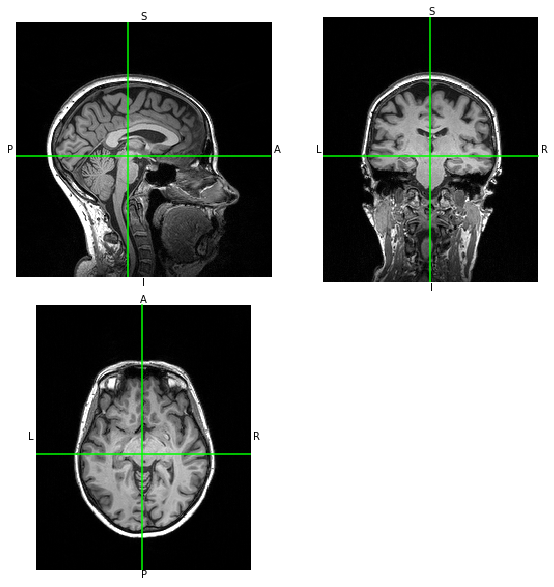

In [19]:
img.orthoview()

## Bias correction
Notice how in the white matter you can see some variation in intensity. It slowly varies from darker areas to lighter areas. This is a known issue 

## Tissue segmentation
Next we are going to run a step of identifying tissue types within the brain. The brain is typically divided up into three primary tissue types: 
1. grey matter (GM),
2. white matter (WM), and
3. cerebrospinal fluid (CSF)
Some of these tissue types can be further broken down (for example cortical GM versus subcortical GM)

## Brain parcellation
Another bit of labelling that is quite helpful is to identify brain regions for each voxel. These are really helpful when you wnat to define a region of interest (ROI) to obtain summary metrics for. This is primarily useful for calculating volumes of each structure, but also for multimodal analyiss when you want a high-resolution anatomical region defined to obtain summary metrics in low-resolution images where it is not possible to identify these regions directly.

## Registration
Registration is used for many pipelines. The main goal is to determine the optimal mapping to align corresponding anatomy between it can be used to align different modalities together (for example PET to MR) to a standard space (such as MNI152) and to